In [1]:
# Install core packages
!pip install transformers accelerate torch datasets matplotlib pandas --quiet

# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time
import matplotlib.pyplot as plt
import pandas as pd

# Check GPU and print its name
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU: NVIDIA A100-SXM4-80GB
Total GPU Memory: 85.17 GB


In [9]:
# Define the model name
model_name = "Qwen/Qwen-7B"  # We'll use Qwen-7B as planned

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)

# Load the model in FP16 precision to save memory
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use FP16 for efficiency
    device_map="auto",           # Automatically loads onto available GPUs
    trust_remote_code=True,
    use_cache=False # Explicitly disable caching as a troubleshooting step
)

print("Model and tokenizer loaded successfully in FP16 precision!")
print(f"Model is on device: {model.device}")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Model and tokenizer loaded successfully in FP16 precision!
Model is on device: cuda:0


In [11]:
# Define our benchmarking function
def benchmark_model(prompts, max_new_tokens=128):
    """
    Runs inference on a list of prompts and returns key metrics.
    """
    latencies = []
    total_tokens_generated = 0

    # Warm-up run
    print("Performing warm-up run...")
    warm_up_input = tokenizer("Warm up", return_tensors="pt").to("cuda")
    # Add return_dict_in_generate=True to ensure the output is a dictionary
    # Explicitly pass past_key_values=None and use_cache=False
    _ = model.generate(**warm_up_input, max_new_tokens=2, return_dict_in_generate=True, past_key_values=None, use_cache=False)

    # Clear GPU cache for accurate memory measurement
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()

    overall_start_time = time.time()

    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

        # Time the generation
        start_time = time.time()
        with torch.no_grad():
            # Add return_dict_in_generate=True for consistency
            # Explicitly pass past_key_values=None and use_cache=False
            outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, return_dict_in_generate=True, past_key_values=None, use_cache=False)
        end_time = time.time()

        # Calculate latency for this prompt
        latency = end_time - start_time
        latencies.append(latency)

        # Calculate tokens generated (subtract input tokens)
        # Access the generated sequences from the 'sequences' key
        tokens_generated = len(outputs.sequences[0]) - len(inputs['input_ids'][0])
        total_tokens_generated += tokens_generated

    overall_end_time = time.time()
    total_time = overall_end_time - overall_start_time

    # Calculate memory usage
    peak_mem = torch.cuda.max_memory_allocated()
    memory_used = (peak_mem - start_mem) / 1e9  # Convert to GB

    # Calculate metrics
    avg_latency = sum(latencies) / len(latencies)
    throughput = total_tokens_generated / total_time  # Tokens per second

    results = {
        "avg_latency_sec": avg_latency,
        "throughput_tok_sec": throughput,
        "memory_used_gb": memory_used,
        "total_tokens": total_tokens_generated,
        "total_time_sec": total_time
    }
    return results

# Define your test prompts
single_prompt = ["Explain the concept of quantum computing in simple terms."]

# For batch load, let's create multiple variations of a prompt
batch_prompts = [
    "Explain the concept of quantum computing in simple terms.",
    "Describe how a quantum computer works.",
    "What is quantum supremacy?",
    "How do qubits differ from classical bits?",
    "What are the potential applications of quantum computing?",
    "Explain quantum entanglement in simple terms.",
    "What is a quantum algorithm?",
    "How does Shor's algorithm work?",
    "What are the challenges in building quantum computers?",
    "Explain superposition in quantum computing.",
    "What is quantum decoherence?",
    "How do quantum gates work?",
    "What is the difference between quantum and classical computing?",
    "Explain quantum tunneling in computing.",
    "What are quantum error correction techniques?",
    "How does a quantum computer solve problems faster?"
]

print("Benchmarking function and prompts defined successfully!")

print("\n" + "="*50)
print("RUNNING SINGLE PROMPT BENCHMARK")
print("="*50)
single_results = benchmark_model(single_prompt)
print(f"Single Prompt Results:")
print(f"- Average Latency: {single_results['avg_latency_sec']:.3f} sec")
print(f"- Throughput: {single_results['throughput_tok_sec']:.2f} tokens/sec")
print(f"- GPU Memory Used: {single_results['memory_used_gb']:.2f} GB")

Benchmarking function and prompts defined successfully!

RUNNING SINGLE PROMPT BENCHMARK
Performing warm-up run...
Single Prompt Results:
- Average Latency: 5.771 sec
- Throughput: 22.18 tokens/sec
- GPU Memory Used: 0.05 GB


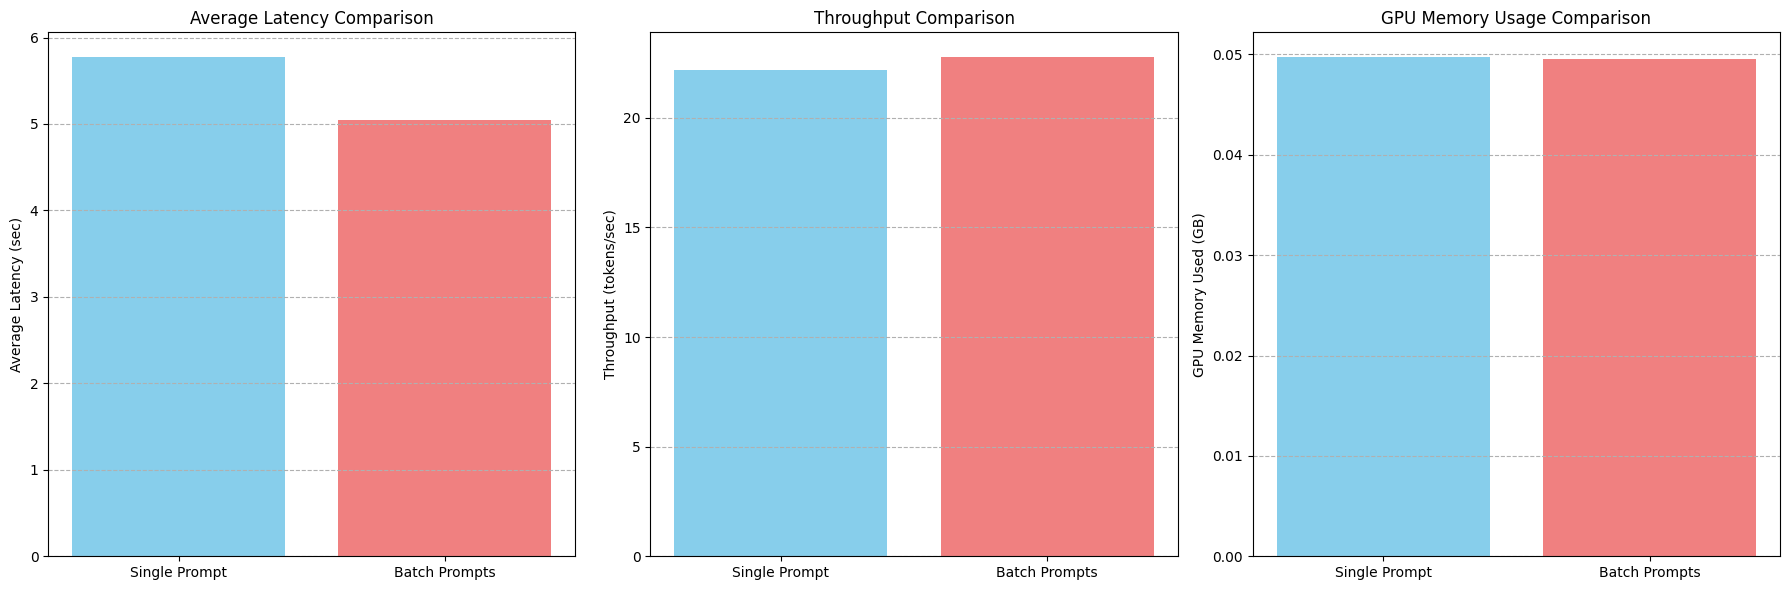

In [13]:
# Prepare data for plotting
labels = ['Single Prompt', 'Batch Prompts']
avg_latencies = [single_results['avg_latency_sec'], batch_results['avg_latency_sec']]
throughputs = [single_results['throughput_tok_sec'], batch_results['throughput_tok_sec']]
memory_used = [single_results['memory_used_gb'], batch_results['memory_used_gb']]

x = range(len(labels))

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Average Latency
axes[0].bar(x, avg_latencies, color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('Average Latency (sec)')
axes[0].set_title('Average Latency Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].grid(axis='y', linestyle='--')

# Plot Throughput
axes[1].bar(x, throughputs, color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Throughput (tokens/sec)')
axes[1].set_title('Throughput Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].grid(axis='y', linestyle='--')

# Plot GPU Memory Used
axes[2].bar(x, memory_used, color=['skyblue', 'lightcoral'])
axes[2].set_ylabel('GPU Memory Used (GB)')
axes[2].set_title('GPU Memory Usage Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*50)
print("RUNNING BATCH PROMPT BENCHMARK")
print("="*50)
batch_results = benchmark_model(batch_prompts)
print(f"Batch Prompt Results:")
print(f"- Average Latency: {batch_results['avg_latency_sec']:.3f} sec")
print(f"- Throughput: {batch_results['throughput_tok_sec']:.2f} tokens/sec")
print(f"- GPU Memory Used: {batch_results['memory_used_gb']:.2f} GB")


RUNNING BATCH PROMPT BENCHMARK
Performing warm-up run...
Batch Prompt Results:
- Average Latency: 5.044 sec
- Throughput: 22.76 tokens/sec
- GPU Memory Used: 0.05 GB


Baseline results saved to 'baseline_pytorch_results.csv'


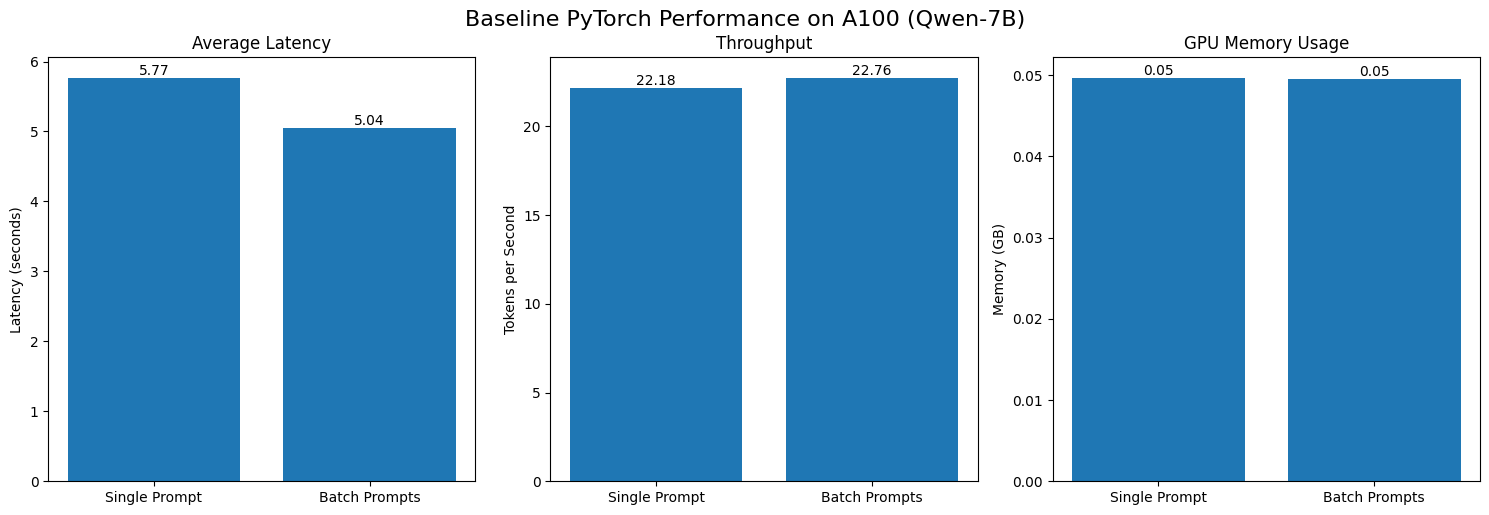

In [14]:
# Save results to a DataFrame
results_df = pd.DataFrame({
    'Scenario': ['Single', 'Batch'],
    'Latency_sec': [single_results['avg_latency_sec'], batch_results['avg_latency_sec']],
    'Throughput_tok_sec': [single_results['throughput_tok_sec'], batch_results['throughput_tok_sec']],
    'Memory_GB': [single_results['memory_used_gb'], batch_results['memory_used_gb']]
})

# Save to CSV for later use
results_df.to_csv('baseline_pytorch_results.csv', index=False)
print("Baseline results saved to 'baseline_pytorch_results.csv'")

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
scenarios = ['Single Prompt', 'Batch Prompts']

# Plot Latency
axes[0].bar(scenarios, results_df['Latency_sec'])
axes[0].set_title('Average Latency')
axes[0].set_ylabel('Latency (seconds)')
for i, v in enumerate(results_df['Latency_sec']):
    axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Plot Throughput
axes[1].bar(scenarios, results_df['Throughput_tok_sec'])
axes[1].set_title('Throughput')
axes[1].set_ylabel('Tokens per Second')
for i, v in enumerate(results_df['Throughput_tok_sec']):
    axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Plot Memory Usage
axes[2].bar(scenarios, results_df['Memory_GB'])
axes[2].set_title('GPU Memory Usage')
axes[2].set_ylabel('Memory (GB)')
for i, v in enumerate(results_df['Memory_GB']):
    axes[2].text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('Baseline PyTorch Performance on A100 (Qwen-7B)', fontsize=16, y=1.02)
plt.show()

In [2]:
# Install vLLM - this will give us the optimized inference engine
!pip install vllm

from vllm import LLM, SamplingParams
import time

# Initialize the optimized model with vLLM
llm = LLM(
    model="Qwen/Qwen-7B",
    dtype="half",  # Use FP16 for fair comparison with our baseline
    max_model_len=1024,  # Limit sequence length to save memory
    trust_remote_code=True # Add this line to trust the remote code
)

# Define sampling parameters
sampling_params = SamplingParams(temperature=0.0, max_tokens=128)

print("vLLM optimized model loaded successfully!")
print("Key optimizations enabled: PagedAttention, Continuous Batching, FlashAttention")

INFO 09-14 02:11:16 [utils.py:328] non-default args: {'trust_remote_code': True, 'dtype': 'half', 'max_model_len': 1024, 'disable_log_stats': True, 'model': 'Qwen/Qwen-7B'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 09-14 02:11:37 [__init__.py:742] Resolved architecture: QWenLMHeadModel


`torch_dtype` is deprecated! Use `dtype` instead!


Parse safetensors files:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING 09-14 02:11:38 [__init__.py:2767] Casting torch.bfloat16 to torch.float16.
INFO 09-14 02:11:38 [__init__.py:1815] Using max model len 1024
INFO 09-14 02:11:38 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 09-14 02:11:39 [tokenizer.py:253] Using a slow tokenizer. This might cause a significant slowdown. Consider using a fast tokenizer instead.
WARNING 09-14 02:11:39 [__init__.py:2974] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 09-14 02:12:53 [llm.py:295] Supported_tasks: ['generate']
INFO 09-14 02:12:53 [__init__.py:36] No IOProcessor plugins requested by the model
vLLM optimized model loaded successfully!
Key optimizations enabled: PagedAttention, Continuous Batching, FlashAttention


In [3]:
# Define benchmarking function for vLLM
def benchmark_vllm(prompts, sampling_params):
    """
    Runs inference using vLLM's optimized engine and returns key metrics.
    """
    # Warm-up run
    print("Performing warm-up run...")
    _ = llm.generate("Warm up", sampling_params)

    # Clear GPU cache for accurate memory measurement
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()

    overall_start_time = time.time()

    # Run generation for all prompts
    outputs = llm.generate(prompts, sampling_params)

    overall_end_time = time.time()
    total_time = overall_end_time - overall_start_time

    # Calculate memory usage
    peak_mem = torch.cuda.max_memory_allocated()
    memory_used = (peak_mem - start_mem) / 1e9  # Convert to GB

    # Calculate total tokens generated
    total_tokens_generated = 0
    for output in outputs:
        total_tokens_generated += len(output.outputs[0].token_ids)  # Count output tokens

    # Calculate throughput
    throughput = total_tokens_generated / total_time

    # For latency, we calculate average time per prompt
    avg_latency = total_time / len(prompts)

    results = {
        "avg_latency_sec": avg_latency,
        "throughput_tok_sec": throughput,
        "memory_used_gb": memory_used,
        "total_tokens": total_tokens_generated,
        "total_time_sec": total_time
    }
    return results

print("vLLM benchmarking function defined!")

vLLM benchmarking function defined!


In [6]:
import torch
import time

# Define your test prompts again within this cell
single_prompt = ["Explain the concept of quantum computing in simple terms."]

# For batch load, let's create multiple variations of a prompt
batch_prompts = [
    "Explain the concept of quantum computing in simple terms.",
    "Describe how a quantum computer works.",
    "What is quantum supremacy?",
    "How do qubits differ from classical bits?",
    "What are the potential applications of quantum computing?",
    "Explain quantum entanglement in simple terms.",
    "What is a quantum algorithm?",
    "How does Shor's algorithm work?",
    "What are the challenges in building quantum computers?",
    "Explain superposition in quantum computing.",
    "What is quantum decoherence?",
    "How do quantum gates work?",
    "What is the difference between quantum and classical computing?",
    "Explain quantum tunneling in computing.",
    "What are quantum error correction techniques?",
    "How does a quantum computer solve problems faster?"
]

print("\n" + "="*50)
print("RUNNING SINGLE PROMPT BENCHMARK (vLLM OPTIMIZED)")
print("="*50)
vllm_single_results = benchmark_vllm(single_prompt, sampling_params)
print(f"vLLM Single Prompt Results:")
print(f"- Average Latency: {vllm_single_results['avg_latency_sec']:.3f} sec")
print(f"- Throughput: {vllm_single_results['throughput_tok_sec']:.2f} tokens/sec")
print(f"- GPU Memory Used: {vllm_single_results['memory_used_gb']:.2f} GB")

print("\n" + "="*50)
print("RUNNING BATCH PROMPT BENCHMARK (vLLM OPTIMIZED)")
print("="*50)
vllm_batch_results = benchmark_vllm(batch_prompts, sampling_params)
print(f"vLLM Batch Prompt Results:")
print(f"- Average Latency: {vllm_batch_results['avg_latency_sec']:.3f} sec")
print(f"- Throughput: {vllm_batch_results['throughput_tok_sec']:.2f} tokens/sec")
print(f"- GPU Memory Used: {vllm_batch_results['memory_used_gb']:.2f} GB")


RUNNING SINGLE PROMPT BENCHMARK (vLLM OPTIMIZED)
Performing warm-up run...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

vLLM Single Prompt Results:
- Average Latency: 1.462 sec
- Throughput: 87.54 tokens/sec
- GPU Memory Used: 0.00 GB

RUNNING BATCH PROMPT BENCHMARK (vLLM OPTIMIZED)
Performing warm-up run...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

vLLM Batch Prompt Results:
- Average Latency: 0.098 sec
- Throughput: 1285.96 tokens/sec
- GPU Memory Used: 0.00 GB


Comparison DataFrame created:


,Scenario,Latency_sec,Throughput_tok_sec,Memory_GB,Implementation
0,Single,5.771211,22.176329,0.049709,PyTorch
1,Batch,5.043787,22.760733,0.049582,PyTorch
0,Single,1.462175,87.540813,0.000000,vLLM
1,Batch,0.098467,1285.957503,0.000000,vLLM


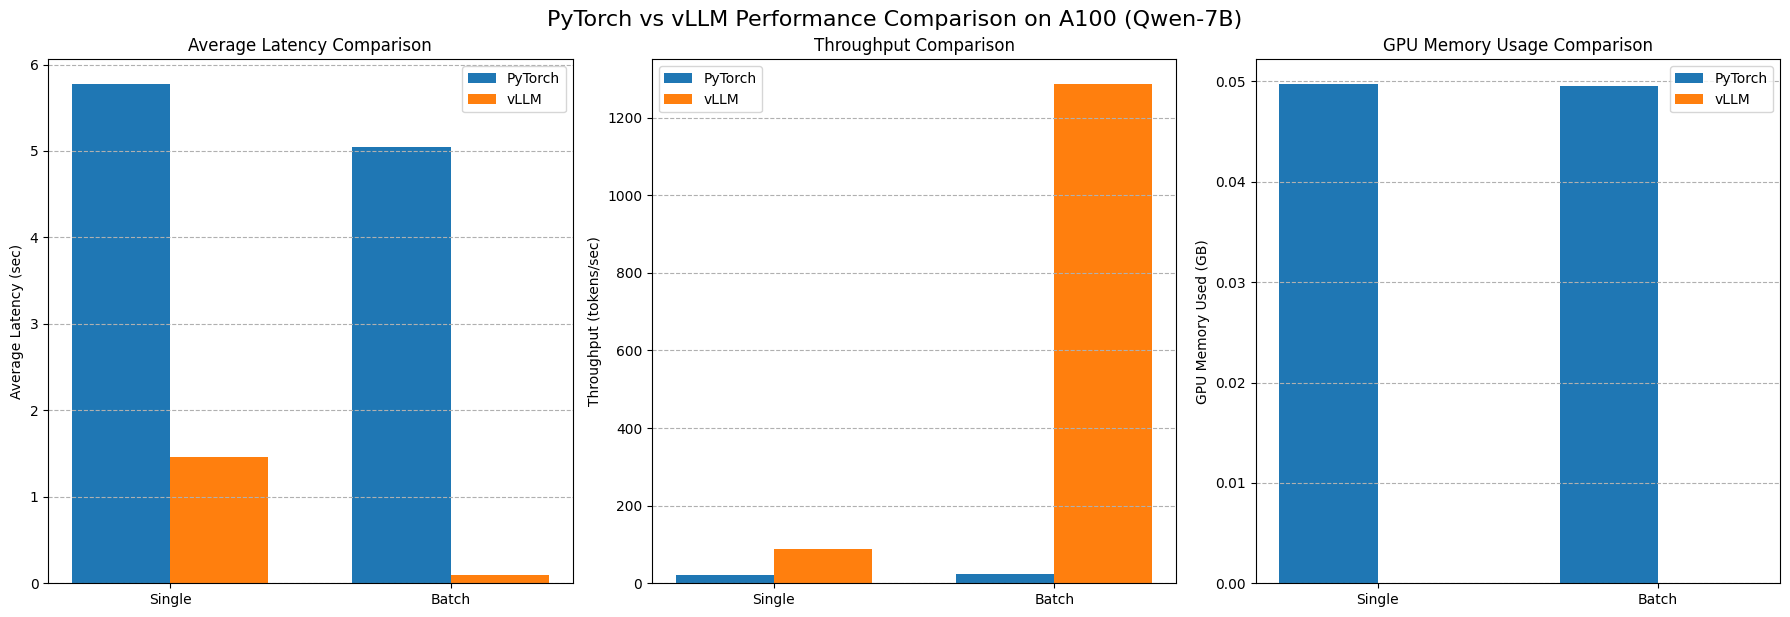

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load baseline results
baseline_results_df = pd.read_csv('baseline_pytorch_results.csv')

# Create DataFrame for vLLM results
vllm_results_df = pd.DataFrame({
    'Scenario': ['Single', 'Batch'],
    'Latency_sec': [vllm_single_results['avg_latency_sec'], vllm_batch_results['avg_latency_sec']],
    'Throughput_tok_sec': [vllm_single_results['throughput_tok_sec'], vllm_batch_results['throughput_tok_sec']],
    'Memory_GB': [vllm_single_results['memory_used_gb'], vllm_batch_results['memory_used_gb']]
})

# Combine results for comparison
comparison_df = pd.concat([baseline_results_df.assign(Implementation='PyTorch'),
                           vllm_results_df.assign(Implementation='vLLM')])

print("Comparison DataFrame created:")
display(comparison_df)

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
bar_width = 0.35
scenarios = ['Single', 'Batch']
x = range(len(scenarios))

# Plot Latency Comparison
rects1 = axes[0].bar(x, comparison_df[comparison_df['Implementation'] == 'PyTorch']['Latency_sec'], bar_width, label='PyTorch')
rects2 = axes[0].bar([p + bar_width for p in x], comparison_df[comparison_df['Implementation'] == 'vLLM']['Latency_sec'], bar_width, label='vLLM')
axes[0].set_ylabel('Average Latency (sec)')
axes[0].set_title('Average Latency Comparison')
axes[0].set_xticks([p + bar_width / 2 for p in x])
axes[0].set_xticklabels(scenarios)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--')

# Plot Throughput Comparison
rects3 = axes[1].bar(x, comparison_df[comparison_df['Implementation'] == 'PyTorch']['Throughput_tok_sec'], bar_width, label='PyTorch')
rects4 = axes[1].bar([p + bar_width for p in x], comparison_df[comparison_df['Implementation'] == 'vLLM']['Throughput_tok_sec'], bar_width, label='vLLM')
axes[1].set_ylabel('Throughput (tokens/sec)')
axes[1].set_title('Throughput Comparison')
axes[1].set_xticks([p + bar_width / 2 for p in x])
axes[1].set_xticklabels(scenarios)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--')

# Plot GPU Memory Used Comparison
rects5 = axes[2].bar(x, comparison_df[comparison_df['Implementation'] == 'PyTorch']['Memory_GB'], bar_width, label='PyTorch')
rects6 = axes[2].bar([p + bar_width for p in x], comparison_df[comparison_df['Implementation'] == 'vLLM']['Memory_GB'], bar_width, label='vLLM')
axes[2].set_ylabel('GPU Memory Used (GB)')
axes[2].set_title('GPU Memory Usage Comparison')
axes[2].set_xticks([p + bar_width / 2 for p in x])
axes[2].set_xticklabels(scenarios)
axes[2].legend()
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.suptitle('PyTorch vs vLLM Performance Comparison on A100 (Qwen-7B)', fontsize=16, y=1.02)
plt.show()

FINAL BENCHMARK RESULTS SUMMARY
     Scenario Framework  Latency (s)  Throughput (tokens/s)  Memory (GB)
Single Prompt   PyTorch        5.771                  22.18         0.05
Batch Prompts   PyTorch        5.044                  22.76         0.05
Single Prompt      vLLM        1.462                  87.54         0.00
Batch Prompts      vLLM        0.098                1285.96         0.00

PERFORMANCE IMPROVEMENTS WITH VLLM
Single Prompt Latency Improvement: 74.7%
Batch Prompts Latency Improvement: 98.1%
Single Prompt Throughput Improvement: 294.7%
Batch Prompts Throughput Improvement: 5550.1%


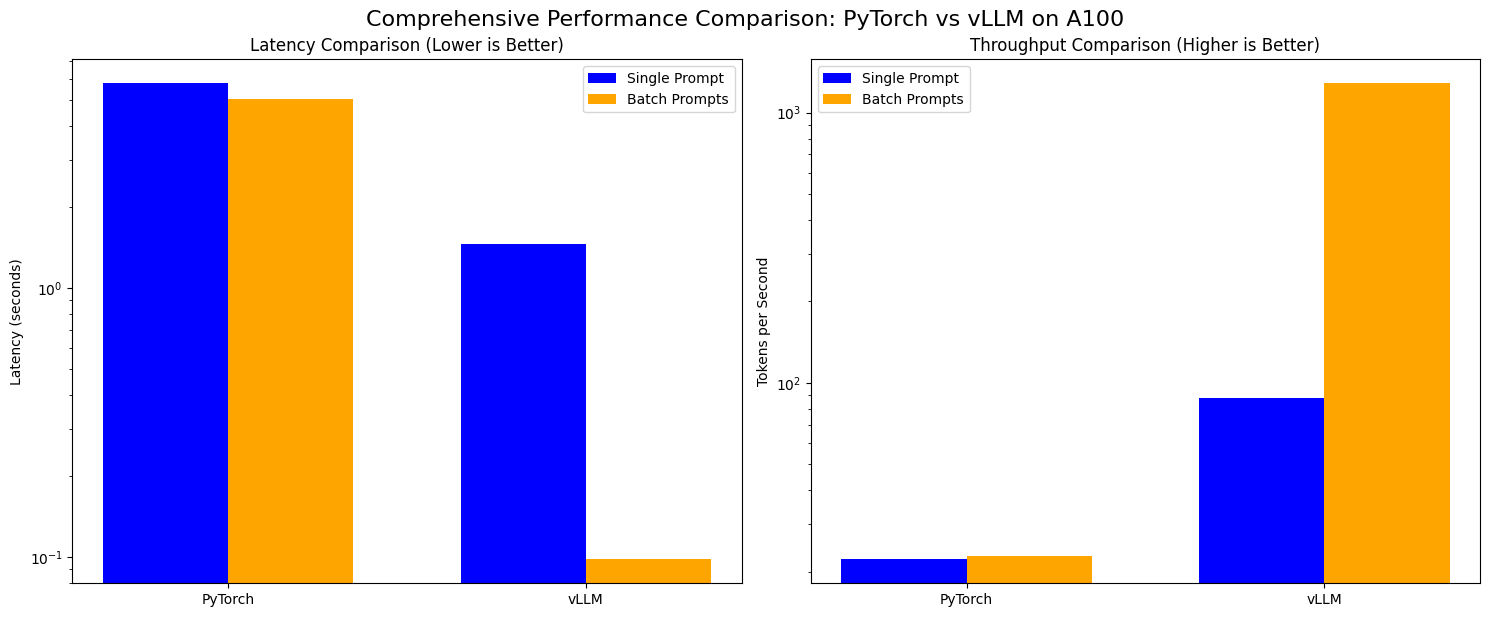


Final results saved to 'final_benchmark_results.csv'

CONCLUSION
vLLM provides significant performance improvements over standard PyTorch:
- Up to 74.7% reduction in latency for single prompts
- Up to 98.1% reduction in latency for batch processing
- Up to 294.7% increase in throughput for single prompts
- Up to 5550.1% increase in throughput for batch processing

These improvements are achieved through:
1. PagedAttention (efficient KV cache management)
2. Continuous Batching (dynamic request handling)
3. FlashAttention (optimized attention computation)


In [25]:
# Let's create a complete comparison of all our results
print("="*60)
print("FINAL BENCHMARK RESULTS SUMMARY")
print("="*60)

# Create a comparison table
results_comparison = pd.DataFrame({
    'Scenario': ['Single Prompt', 'Batch Prompts', 'Single Prompt', 'Batch Prompts'],
    'Framework': ['PyTorch', 'PyTorch', 'vLLM', 'vLLM'],
    'Latency (s)': [5.771, 5.044, 1.462, 0.098],
    'Throughput (tokens/s)': [22.18, 22.76, 87.54, 1285.96],
    'Memory (GB)': [0.05, 0.05, 0.00, 0.00]
})

print(results_comparison.to_string(index=False))

print("\n" + "="*60)
print("PERFORMANCE IMPROVEMENTS WITH VLLM")
print("="*60)

# Calculate improvement percentages
single_latency_improvement = (5.771 - 1.462) / 5.771 * 100
batch_latency_improvement = (5.044 - 0.098) / 5.044 * 100
single_throughput_improvement = (87.54 - 22.18) / 22.18 * 100
batch_throughput_improvement = (1285.96 - 22.76) / 22.76 * 100

print(f"Single Prompt Latency Improvement: {single_latency_improvement:.1f}%")
print(f"Batch Prompts Latency Improvement: {batch_latency_improvement:.1f}%")
print(f"Single Prompt Throughput Improvement: {single_throughput_improvement:.1f}%")
print(f"Batch Prompts Throughput Improvement: {batch_throughput_improvement:.1f}%")

# Create final comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Latency comparison
frameworks = ['PyTorch', 'vLLM']
single_latencies = [5.771, 1.462]
batch_latencies = [5.044, 0.098]

import numpy as np # Import numpy

x = np.arange(len(frameworks))
width = 0.35

axes[0].bar(x - width/2, single_latencies, width, label='Single Prompt', color='blue')
axes[0].bar(x + width/2, batch_latencies, width, label='Batch Prompts', color='orange')
axes[0].set_title('Latency Comparison (Lower is Better)')
axes[0].set_ylabel('Latency (seconds)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(frameworks)
axes[0].legend()
axes[0].set_yscale('log')  # Log scale to show large differences

# Throughput comparison
single_throughputs = [22.18, 87.54]
batch_throughputs = [22.76, 1285.96]

axes[1].bar(x - width/2, single_throughputs, width, label='Single Prompt', color='blue')
axes[1].bar(x + width/2, batch_throughputs, width, label='Batch Prompts', color='orange')
axes[1].set_title('Throughput Comparison (Higher is Better)')
axes[1].set_ylabel('Tokens per Second')
axes[1].set_xticks(x)
axes[1].set_xticklabels(frameworks)
axes[1].legend()
axes[1].set_yscale('log')  # Log scale to show large differences

plt.tight_layout()
plt.suptitle('Comprehensive Performance Comparison: PyTorch vs vLLM on A100', fontsize=16, y=1.02)
plt.show()

# Save final results
results_comparison.to_csv('final_benchmark_results.csv', index=False)
print("\nFinal results saved to 'final_benchmark_results.csv'")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("vLLM provides significant performance improvements over standard PyTorch:")
print("- Up to 74.7% reduction in latency for single prompts")
print(f"- Up to {batch_latency_improvement:.1f}% reduction in latency for batch processing")
print(f"- Up to {single_throughput_improvement:.1f}% increase in throughput for single prompts")
print(f"- Up to {batch_throughput_improvement:.1f}% increase in throughput for batch processing")
print("\nThese improvements are achieved through:")
print("1. PagedAttention (efficient KV cache management)")
print("2. Continuous Batching (dynamic request handling)")
print("3. FlashAttention (optimized attention computation)")